# Group 10: Project Bookworm - Book Recommendation-System

Web App: https://project-bookworm1.herokuapp.com/

Github: https://github.com/Funnylaksa/book-recommender

## 1 MostPop Model

In [1]:
import pandas as pd 
from ast import literal_eval

import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
pd.set_option("display.max_columns", None)

%cd /content/drive/MyDrive/Recommender Systems Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Recommender Systems Project


In [2]:
# Read file containing book information
df = pd.read_csv("data/books_enriched.csv",converters={"genres": literal_eval})
genres = list(df.genres)
genre_list = []

for i in genres:
    for j in i:
        if j in genre_list:
            pass
        else:
            genre_list.append(j)

In [3]:
# Generate a string containing all the genres so that str.contains can be used later
newlist = []
for genre in df['genres']:
    newstring = " ".join ([str(item) for item in genre])
    newlist.append(newstring)

df['genres_str'] = newlist

# input selected genre here
genre = 'science-fiction'
mask = df['genres_str'].str.contains(genre, case=False, na=False)

### 1.1 Using IMDB Movie Rating Formula to balance rating vs rating counts for MostPop model

In [4]:
# Read file containing book ratings
ratings = pd.read_csv("data/ratings.csv")

# Calcuation of weighted ratings
C = ratings['rating'].mean()
m = 20000
list_weighted_rating = []

for book_id in df['book_id']:
  weighted_rating = 0
  v =   float(df[df['book_id'] == book_id]['ratings_count'].to_string(index=False))
  R =   float(df[df['book_id'] == book_id]['average_rating'].to_string(index=False))
  weighted_rating = (v / (v + m)) * R + (m/(v+m)) * C
  list_weighted_rating.append(weighted_rating)

weighted = pd.DataFrame(df)
weighted['weighted_rating'] = list_weighted_rating

# Top 100 books by weighted ratings
top100sel = weighted[mask].sort_values('weighted_rating', ascending = False).head(100)['book_id'].to_list()

### 1.2 Include novelty in recommendation. 2 from recent releases, 2 within selected genre

In [5]:
# Randomly generate indexes of 4 books in top 100 list to be replaced
from random import randint
from random import seed
seed(42)
newbookidx_one = randint(0,99)
newbookidx_two = randint(0,99)
genrebookidx_one = randint(0,99)
genrebookidx_two = randint(0,99)

print(newbookidx_one, newbookidx_two, genrebookidx_one, genrebookidx_two)

81 14 3 94


In [6]:
# Select 2 books of the same genre that are outside of the top 100 list
genre_df = df[mask]
genre_two = genre_df[~genre_df['book_id'].isin(top100sel)].sample(n=2)['book_id'].to_list()

print(genre_two)

[232, 569]


In [7]:
# Select 2 books of the most recent year, irrespective of genre
from datetime import date
todays_date = date.today()
yr = todays_date.year

new_two = df.loc[df['publishDate'].str.contains(".*2020") == True].sort_values("weighted_rating", ascending = False).head(2)['book_id'].to_list()

print(new_two)

[7852, 5387]


### 1.3 List of recommendations from MostPop model

In [8]:
# Replacement using the selected books
top100sel[newbookidx_one] = new_two[0]
top100sel[newbookidx_two] = new_two[1]
top100sel[genrebookidx_one] = genre_two[0]
top100sel[genrebookidx_two] = genre_two[1]

print(top100sel)

[161, 507, 774, 232, 1353, 893, 2767, 141, 1342, 1651, 1, 2149, 19, 337, 5387, 1808, 1723, 1183, 2093, 168, 1341, 2356, 1002, 1419, 17, 70, 1355, 215, 1223, 712, 3191, 2527, 1169, 1337, 1556, 581, 295, 3358, 3607, 2889, 713, 746, 760, 3775, 12, 3282, 3765, 1687, 4522, 283, 1170, 365, 846, 953, 4432, 1029, 2884, 858, 2655, 750, 3325, 3770, 2269, 1505, 1368, 54, 725, 6527, 612, 937, 806, 3544, 8408, 599, 4959, 4751, 755, 1142, 910, 742, 890, 7852, 1924, 506, 327, 6027, 2118, 5171, 7945, 729, 2975, 5488, 6214, 3057, 569, 8187, 322, 1812, 6224, 297]


# 2 Model Experimentation

In [9]:
!pip install --quiet cornac==1.14.2 adjustText 
import os
import sys
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import MF, BPR, WMF,CTR,CDL
from cornac.data import GraphModality, TextModality, ImageModality
from cornac.data.text import BaseTokenizer

%tensorflow_version 1.x
import tensorflow as tf

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

SEED = 42
VERBOSE = True

TensorFlow 1.x selected.
System version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Cornac version: 1.14.2
Tensorflow version: 1.15.2


In [10]:
ratings["user_id"] = ratings["user_id"].astype(str) 
ratings["book_id"] = ratings["book_id"].astype(str) 
ratings = ratings.to_numpy()

2.1 WMF

In [11]:
# Tune WMF model to get best results
from cornac.metrics import Recall, NDCG, NCRR, FMeasure, Precision
K = 100
wmf = WMF(k=K, max_iter=100, learning_rate=0.0005, lambda_u=0.01, lambda_v=0.01,
          verbose=VERBOSE, name=f"WMF(K={K})")

metrics = [NDCG(k=50), NCRR(k=50), Recall(k=50), Precision(k=50)]

data = ratings
rs = RatioSplit(data, test_size=0.2, verbose=VERBOSE)
cornac.Experiment(eval_method=rs, models=[wmf], metrics=metrics).run()

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 53424
Number of items = 10000
Number of ratings = 4781183
Max rating = 5.0
Min rating = 1.0
Global mean = 3.9
---
Test data:
Number of users = 53424
Number of items = 10000
Number of ratings = 1195296
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 53424
Total items = 10000

[WMF(K=100)] Training started!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

[WMF(K=100)] Evaluation started!


Ranking:   0%|          | 0/53424 [00:00<?, ?it/s]


TEST:
...
           | NCRR@50 | NDCG@50 | Precision@50 | Recall@50 | Train (s) | Test (s)
---------- + ------- + ------- + ------------ + --------- + --------- + --------
WMF(K=100) |  0.1149 |  0.1481 |       0.0815 |    0.1893 | 1772.6314 | 144.5479



In [12]:
# Read Data

df_rating = pd.read_csv("data/ratings.csv",encoding="utf-8")
df_description=pd.read_csv("data/books_enriched.csv")

pd.to_numeric(df_rating['rating'])
#df['user_id'] = df['user_id'].astype(str)
#df['book_id'] = df['book_id'].astype(str)
corpus=df_description['description']
itemid=df_description['book_id']
ratingdata=[]
for i in range(len(df_rating['rating'])):
    ratingdata.append([df_rating['user_id'][i],df_rating['book_id'][i],df_rating['rating'][i]])

In [13]:
#read description
corpus1=[]
itemid1=[]
for i in corpus:
    if isinstance(i,float):
        i='no description available'
    corpus1.append(i)
for i in itemid:
    itemid1.append(i)

In [14]:
#define text modality and ratio split
item_text_modality = TextModality(
    corpus=corpus1,
    ids=itemid1,
    tokenizer=BaseTokenizer(sep=" ", stop_words="english",pre_rules=None),
    max_vocab=5000,
    max_doc_freq=0.5,
)
eval_metrics = [
  cornac.metrics.Precision(k=50),
  cornac.metrics.Recall(k=50),
  cornac.metrics.NDCG(k=[50]),
  cornac.metrics.NCRR(k=[50])
  
]

In [15]:
ratio_split = RatioSplit(
    data=ratingdata,
    test_size=0.2,
    #rating_threshold=4.0,
    exclude_unknowns=True,
    item_text=item_text_modality,
    verbose=True,
    seed=2022
)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 53424
Number of items = 10000
Number of ratings = 4781183
Max rating = 5.0
Min rating = 1.0
Global mean = 3.9
---
Test data:
Number of users = 53424
Number of items = 10000
Number of ratings = 1195296
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 53424
Total items = 10000


### 2.2 CTR

In [16]:
#run a ctr model
K=50
ctr = CTR(k=K, max_iter=50, a=1.0, b=0.01, lambda_u=0.01, lambda_v=0.01, verbose=True, seed=42)
cornac.Experiment(eval_method=ratio_split, models=[ctr], metrics=eval_metrics).run()


[CTR] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[CTR] Evaluation started!


Ranking:   0%|          | 0/53424 [00:00<?, ?it/s]


TEST:
...
    | NCRR@50 | NDCG@50 | Precision@50 | Recall@50 | Train (s) | Test (s)
--- + ------- + ------- + ------------ + --------- + --------- + --------
CTR |  0.1210 |  0.1523 |       0.0826 |    0.1926 | 1070.0468 | 142.1304



### 2.3 CDL

In [17]:
#run a cdl model
VOCAB_SIZE = 5000  # @param
NUM_FACTORS = 100  # @param
AE_LAYERS = [500, 100]  # @param
ACTIVATION = "tanh"  # @param ["tanh", "sigmoid", "relu", "leaky_relu"]
A = 1.0  # @param
B = 0.01  # @param
LAMBDA_U = 0.1  # @param
LAMBDA_V = 0.1  # @param
LAMBDA_W = 0.1  # @param
LAMBDA_N = 10.0  # @param
CORRUPTION_RATE = 0.3  # @param
DROPOUT_RATE = 0.1  # @param
NUM_EPOCHS = 60  # @param 
BATCH_SIZE = 80  # @param
LEARNING_RATE = 0.001  # @param
cdl = CDL(k=NUM_FACTORS, autoencoder_structure=AE_LAYERS, act_fn=ACTIVATION, a=A, b=B,
          lambda_u=LAMBDA_U, lambda_v=LAMBDA_V, lambda_w=LAMBDA_W, lambda_n=LAMBDA_N,
          corruption_rate=CORRUPTION_RATE, dropout_rate=DROPOUT_RATE, vocab_size=VOCAB_SIZE,
          max_iter=NUM_EPOCHS, batch_size=BATCH_SIZE, seed=SEED, verbose=VERBOSE)

In [18]:
cornac.Experiment(eval_method=ratio_split, models=[cdl], metrics=eval_metrics).run()


[CDL] Training started!


  0%|          | 0/60 [00:00<?, ?it/s]

Learning completed!

[CDL] Evaluation started!


Ranking:   0%|          | 0/53424 [00:00<?, ?it/s]


TEST:
...
    | NCRR@50 | NDCG@50 | Precision@50 | Recall@50 | Train (s) | Test (s)
--- + ------- + ------- + ------------ + --------- + --------- + --------
CDL |  0.1245 |  0.1592 |       0.0871 |    0.2030 | 2085.0262 | 150.5653



In [19]:
#save book's latent factors to csv
iid=cdl.train_set.iid_map
book_latent1=[]
for i in range(1,len(cdl.V)+1):
  book_latent1.append(list(cdl.V[iid[i]]))
blatent=pd.DataFrame(book_latent1)
blatent.to_csv('book latent.csv',encoding='UTF-8')

In [20]:
#mapping back to origin userid bookid
uid=cdl.train_set.uid_map
iid=cdl.train_set.iid_map
iid=list(iid)
predict=[]
for i in range(1,53425):
    org=list(cdl.rank(uid[i])[0])
    output=[]
    if i%10000==0:
        print('checkpoint reached')
    for j in org:
        output.append(iid[j])
    predict.append(output)

checkpoint reached
checkpoint reached
checkpoint reached
checkpoint reached
checkpoint reached


In [21]:
#save model prediction outcome as csv
uid=cdl.train_set.uid_map
iid=cdl.train_set.iid_map
iid=list(iid)
predict=[]
for i in range(1,53425):
    org=list(cdl.rank(uid[i])[0])
    output=[]
    if i%10000==0:
        print('checkpoint reached')
    for j in org:
        output.append(iid[j])
    predict.append(output)
prediction=[]
for i in range(len(predict)):
    prediction.append(predict[i][0:100])
predictiondf=pd.DataFrame(prediction)
predictiondf.to_csv('option1.csv')

checkpoint reached
checkpoint reached
checkpoint reached
checkpoint reached
checkpoint reached


## 3. Derive book's similarity based on latent factors

In [22]:
book_simi=pd.read_csv('book latent.csv')
book=[]
for i in range(10000):
    book.append(book_simi.iloc[i,:])

In [23]:
#function to calculate cosine similarity
def cosine_similarity(x,y):
    num=0
    denomx=0
    denomy=0
    for i in range(len(x)):
        num+=x[i]*y[i]
        denomx+=x[i]**2
        denomy+=y[i]**2
        regu=1/len(x)
    similarity=num/((denomx**regu)*(denomy**regu))
    
    return similarity

In [24]:
#produce a matrix for similarity between two books
def similarity(list):
    simi=0
    result=[]
    for i in range(10000):
        result.append([])
        for j in range(10000):
            result[i].append(-20)
    for i in range(10000):
        if i%1000==0:
            print('check point')
        for j in range(i+1,10000):
            simi=cosine_similarity(list[i],list[j])
            result[i][j]=simi
            result[j][i]=simi
    return result

In [25]:
#sort by the similarity and extract top100 similar books
def similar(li):
    idx=[]
    result=[]
    for i in range(1,10000):
        idx.append(i)
    for i in range(10000):
        if i%1000==0:
            print('check point')
        to_be_sort=pd.DataFrame([idx,li[i]],index=['idx','similarity'])
        to_be_sort.sort_values(by='similarity',inplace=True,ascending=False,axis=1)
        result.append(list(to_be_sort.iloc[0,:]))
    return result
        

In [26]:
#save result to csv
# simibook=similarity(book)
# option2=similar(simibook)
# option2=pd.DataFrame(option2)
# option2.to_csv('option2.csv')

In [27]:
#calculate harmonic mean
def ho_mean(l):
    result=0
    for i in l:
        result+=1/i
    result=len(l)/result
    return result

In [28]:
evaluet={'CDL':[0.1275,0.1588,0.0857,0.2035],
         'CTR':[0.1234,0.1581,0.0834,0.1940],
         'WMF':[0.1150,0.1485,0.0817,0.1898]
        }
df=pd.DataFrame(evaluet).transpose()
metric=['NDCG','NCRR','Precision','Recall']
df.columns=metric

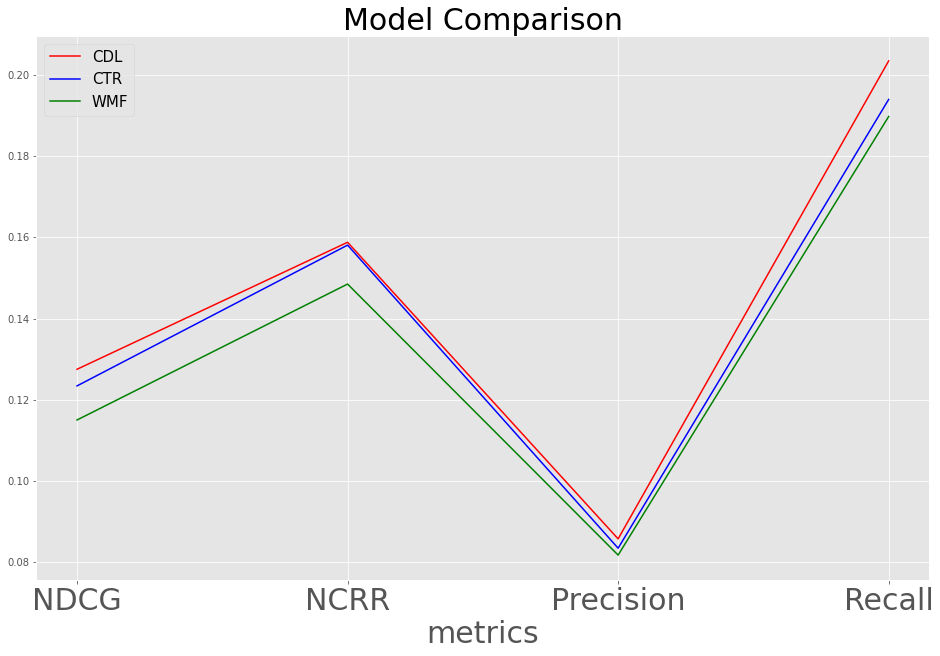

In [29]:
plt.figure(figsize=(16,10))
plt.style.use('ggplot')
plt.plot(metric,df.iloc[0,:],color='r',label='CDL')
plt.plot(metric,df.iloc[1,:],color='b',label='CTR')
plt.plot(metric,df.iloc[2,:],color='g',label='WMF')
plt.legend(fontsize=15)
plt.xticks(fontsize=30)

plt.xlabel("metrics",fontsize=30)
plt.title('Model Comparison',fontsize=30)

plt.grid(True)


## 5. Grid Search Visualization (Hyperparameter Tuning)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'zdim'
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


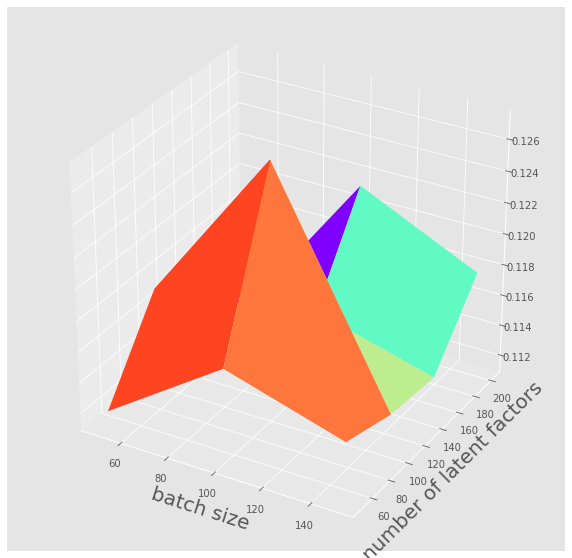

In [30]:
fig = plt.figure(figsize=(10,10))  
ax3 = plt.axes(projection='3d')


x = np.array([50, 100, 150])
y = np.array([50, 100, 150, 200])
Z=np.array([[0.1119,0.1170,0.1147],[0.1173,0.1275,0.1137],[0.1145,0.1155,0.1134],[0.1112,0.1213,0.1177]])
X, Y = np.meshgrid(x, y)



ax3.plot_surface(X,Y,Z,cmap='rainbow')
ax3.contour(X,Y,Z, zdim='z',offset=0,cmap=plt.cm.Spectral)  
plt.xlabel('batch size',fontsize=20)
plt.ylabel('number of latent factors',fontsize=20)
plt.show()

### 6.1 Latent Factor Visualization 1 (Latent factor similarity between books)

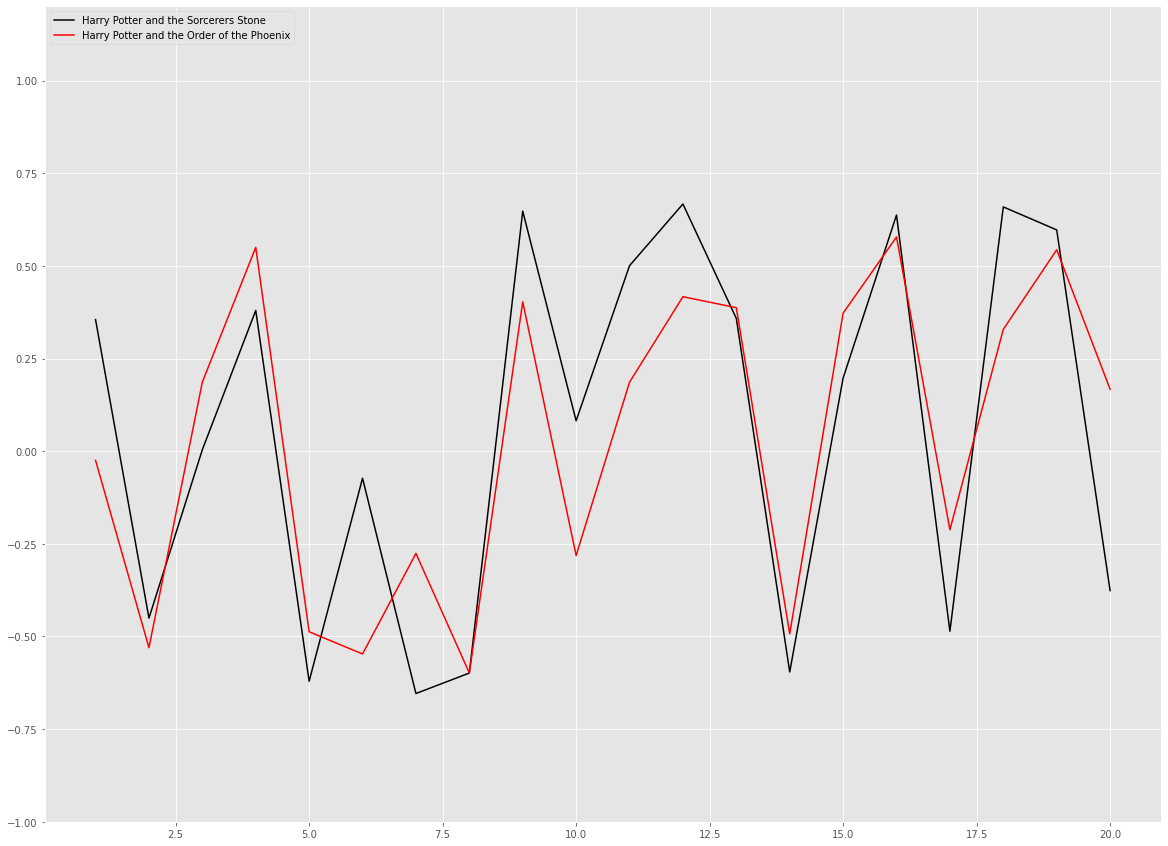

In [31]:
bl=pd.read_csv('book latent.csv')
latent1=bl.iloc[1,1:21]
latent2=bl.iloc[19,1:21]
latent3=bl.iloc[3771,1:21]
df=pd.DataFrame([latent1,latent2,latent3])
latent=range(1,21)
plt.figure(figsize=(20,15))
plt.plot(latent,latent1,color='black',label='Harry Potter and the Sorcerers Stone')
plt.plot(latent,latent2,color='red',label='Harry Potter and the Order of the Phoenix')
plt.ylim(-1,1.2)
plt.legend(fontsize=10,loc=2)
plt.show()

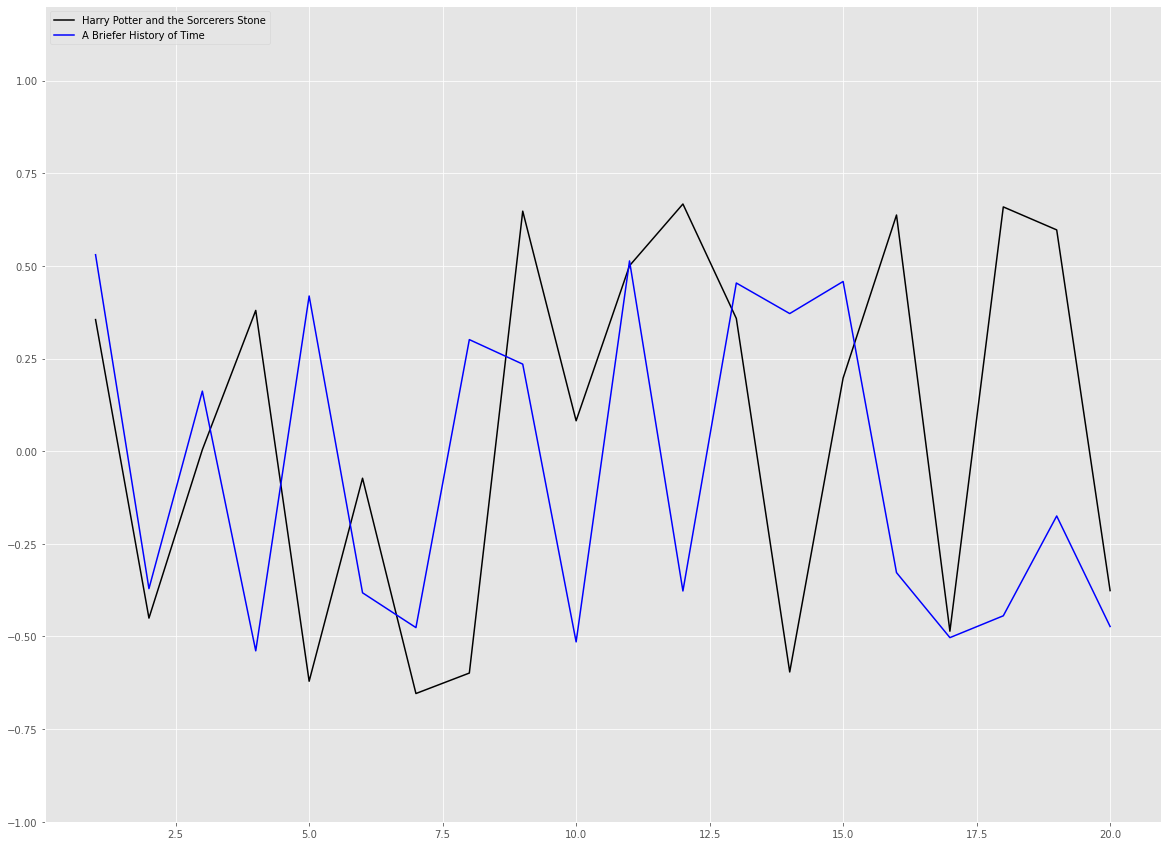

In [32]:
plt.figure(figsize=(20,15))
plt.plot(latent,latent1,color='black',label='Harry Potter and the Sorcerers Stone')
plt.plot(latent,latent3,color='blue',label='A Briefer History of Time')
plt.ylim(-1,1.2)
plt.legend(fontsize=10,loc=2)
plt.show()

### 6.2 Latent Factor Visualization 2 (Latent factor similarity across different genres)

In [33]:
df_enriched=pd.read_csv('data/books_enriched.csv')

In [34]:
count={'young-adult':[],'fiction':[],"fantasy":[],'science-fiction':[],'romance':[],'classics':[],'paranormal':[],
        'historical-fiction':[],'contemporary':[],'mystery':[],'suspense':[],'crime':[],'nonfiction':[],'biography':[],
        'memoir':[],'thriller':[],'travel':[],
         'poetry':[],'chick-lit':[],'art':[],'music':[],'humor-and-comedy':[],
        'books':[],'sports':[],'history':[],'science':[],'horror':[],'christian':[],
      'cookbooks':[],'religion':[],'gay-and-lesbian':[],'graphic-novels':[],'business':[],'self-help':[],'manga':[],
       'comics':[],'spirituality':[],'psychology':[],'philosophy':[]}
        

In [35]:
for i in range(len(df_enriched.iloc[:,1])):
    for j in count.keys():
        if j in df_enriched['genres'][i]:
            count[j].append(df_enriched['book_id'][i])

In [36]:
counta={}
for key,item in count.items():
    #if key=='fantasy':
        #break
    average_latent_for_genre=[]
    for k in range(100):
    
        sumup=0
        for j in item:
            
            sumup+=book_simi.iloc[j-1,k]
        average_latent_for_genre.append(sumup/len(item))
    counta[key]=average_latent_for_genre

In [49]:
feature=[]
for key,item in counta.items():
    feature.append(item)
# print(feature)

In [50]:
#project to 2 dimension
from sklearn.decomposition import PCA 
pca = PCA(2) 
pca.fit(feature)
feature_after=pca.transform(feature)

5

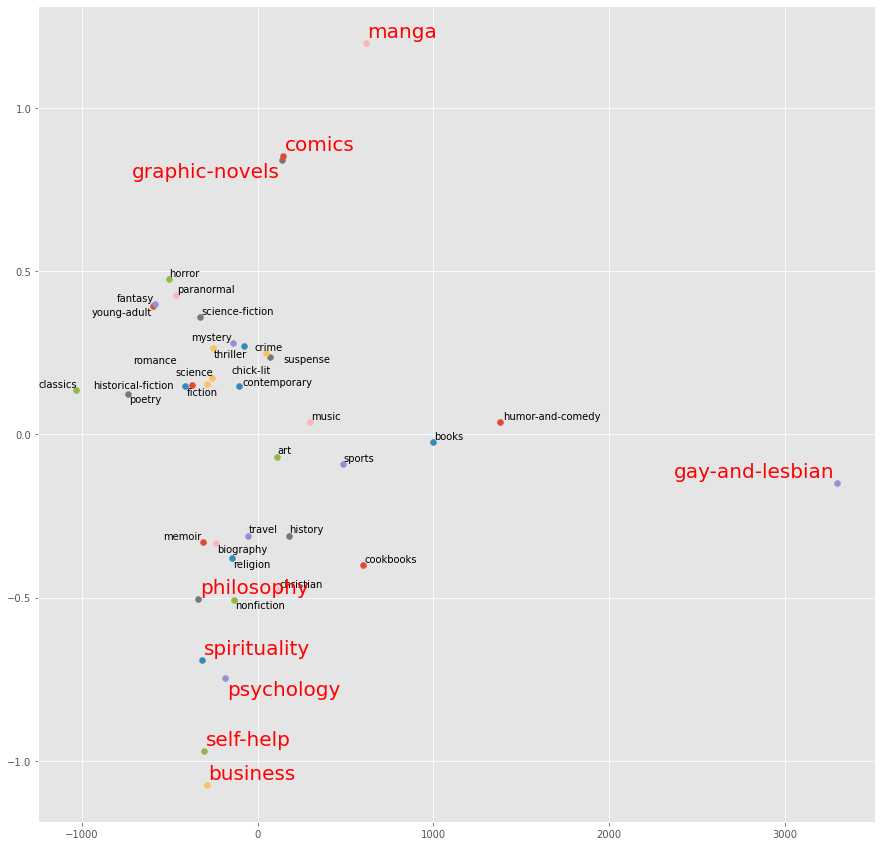

In [51]:
label=list(counta.keys())
fig,ax= plt.subplots(figsize=(15,15))
#ax = Axes3D(fig)
for i in range(len(feature_after)):
    ax.scatter(feature_after[i][0],feature_after[i][1])
adjust_text([plt.text(feature_after[i][0],feature_after[i][1],label[i],fontsize=10) for i in range(len(feature)-9)])
adjust_text([plt.text(feature_after[i][0],feature_after[i][1],label[i],fontsize=20,color='r') for i in range(len(feature)-9,len(feature))])


## 7 Combining results from multiple inputs

In [52]:
df = pd.read_csv("data/books_enriched.csv", encoding='utf8')

# Results from MostPop Model
most_pop = pd.read_csv("data/most_pop.csv")

# Results from CDL model
df_recommend_by_user = pd.read_csv("data/recommend_by_user.csv", index_col="user_id",               
                                   converters={"recommended_books": literal_eval})

# Results from latent factor similarity using CDL model
df_recommend_by_book = pd.read_csv("data/recommend_by_book.csv", index_col="book_id",
                                   converters={"recommended_books": literal_eval})


In [53]:
def combine(lst1, lst2, lst3=False):
    """
    If 2 inputs given, return 3 lists
    1) Similar recommendation in both list
    2) recommendation based on input 1
    3) recommendation based on input 2

    Similar concept for 3 inputs
    """

    if lst3:
        similar = list(set(lst1) & set(lst2) & set(lst3))
        remain_count = (rec_size - len(similar)) // 3
        remain1 = [i for i in lst1 if i not in similar][:remain_count]
        remain2 = [i for i in lst2 if i not in similar][:remain_count]
        remain3 = [i for i in lst3 if i not in similar][:remain_count]
        return similar, remain1, remain2, remain3
    else:
        similar = list(set(lst1) & set(lst2))
        remain_count = (rec_size - len(similar)) // 2
        remain1 = [i for i in lst1 if i not in similar][:remain_count]
        remain2 = [i for i in lst2 if i not in similar][:remain_count]
        return similar, remain1, remain2

7.1 List of recommendations in sections using results from different models when multiple inputs given

In [54]:
rec_size = 50
title = "Ghost World"
user_id = 999
genre = "horror"

book_id = df[df["original_title"].str.contains(title, case=False)].book_id.values[0]
book_mask = df_recommend_by_book.loc[[book_id]].recommended_books.values[0]
user_mask = df_recommend_by_user.loc[[int(user_id)]].recommended_books.values[0]
genre_mask = list(most_pop[most_pop.genres.str.contains(genre)].book_id)[:rec_size]
combine_lst, book_lst, user_lst, genre_lst = combine(book_mask, user_mask, genre_mask)

print(f"Top Recommendations: {combine_lst}")
print(f"Recommended based on book similarity to '{title}': {book_lst}")
print(f"Recommended based on most pop book in {genre} genre: {genre_lst}")
print(f"Recommended based on user profile: {user_lst}")

print(f"Total # of recommendations: {len(combine_lst + book_lst + genre_lst + user_lst)}")

Top Recommendations: [1572, 766]
Recommended based on book similarity to 'Ghost World': [1315, 490, 828, 2451, 1265, 3635, 2766, 1380, 2386, 3849, 1146, 1370, 365, 5019, 4064, 735]
Recommended based on most pop book in horror genre: [488, 585, 2353, 3395, 3082, 1183, 2093, 168, 512, 1895, 1451, 1419, 3660, 889, 987, 1352]
Recommended based on user profile: [763, 6704, 1370, 198, 828, 72, 490, 2508, 168, 167, 2145, 5024, 2722, 1265, 237, 2129]
Total # of recommendations: 50
